## Dependencies

In [1]:
import json, warnings, shutil
from jigsaw_utility_scripts import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])

print('Train set samples: %d' % len(k_fold))
print('Validation set samples: %d' % len(valid_df))
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_1.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_2.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_3.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_4.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_5.tar.gz

Train set samples: 435775
Validation set samples: 8000


,index,comment_text,toxic,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,Explanation\nWhy the edits made under my usern...,0,train,validation,train,train,train
1,1,D'aww! He matches this background colour I'm s...,0,train,validation,train,train,train
2,2,"Hey man, I'm really not trying to edit war. It...",0,train,train,train,train,validation
3,3,"""\nMore\nI can't make any real suggestions on ...",0,train,validation,train,train,train
4,4,"You, sir, are my hero. Any chance you remember...",0,train,train,train,train,validation


fold_1/
fold_1/y_train.npy
fold_1/x_valid.npy
fold_1/x_train.npy
fold_1/y_valid.npy


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 16 * strategy.num_replicas_in_sync,
  "EPOCHS": 3,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": 1,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [5]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    sequence_output = base_model({'input_ids': input_ids})
    
    last_state = sequence_output[0]
    cls_token = last_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(), metrics.AUC()])
    
    return model

In [6]:
# Datasets
def get_training_dataset(x_train, y_train, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train}, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid}, y_valid))
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test})
    dataset = dataset.batch(batch_size)
    return dataset

# Train

In [7]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    x_valid_ml = np.load(database_base_path + 'x_valid.npy')
    y_valid_ml = np.load(database_base_path + 'y_valid.npy')
    
    step_size = x_train.shape[0] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True, verbose=1)
    
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO),
                        validation_data=(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO)),
                        callbacks=[checkpoint, es],
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        verbose=2).history
        
    history_list.append(history)
    
    # Fine-tune on validation set
    print('\nFine-tune on validation set')
    n_steps2 = x_valid_ml.shape[0] // config['BATCH_SIZE']

    history2 = model.fit(get_training_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO),
                         steps_per_epoch=n_steps2,
#                          epochs=config['EPOCHS'],
                         epochs=1,
                         verbose=2).history
    
    # Make predictions
#     train_preds = model.predict(get_test_dataset(np.load(base_data_path + 'x_train.npy'), config['BATCH_SIZE'], AUTO))
#     valid_preds = model.predict(get_test_dataset(np.load(base_data_path + 'x_valid.npy'), config['BATCH_SIZE'], AUTO))
#     valid_ml_preds = model.predict(get_test_dataset(np.load(database_base_path + 'x_valid.npy'), config['BATCH_SIZE'], AUTO))
    
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'pred_%d' % (n_fold+1)] = np.round(train_preds)
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'pred_%d' % (n_fold+1)] = np.round(valid_preds)
#     valid_df['pred_%d' % (n_fold+1)] = np.round(valid_ml_preds)


FOLD: 1
Train for 2723 steps, validate for 63 steps
Epoch 1/3

Epoch 00001: val_loss improved from inf to 0.46148, saving model to model_fold_1.h5
2723/2723 - 1535s - loss: 0.0971 - binary_accuracy: 0.9647 - auc: 0.9910 - val_loss: 0.4615 - val_binary_accuracy: 0.8463 - val_auc: 0.5325
Epoch 2/3

Epoch 00002: val_loss improved from 0.46148 to 0.29529, saving model to model_fold_1.h5
2723/2723 - 1332s - loss: 0.0923 - binary_accuracy: 0.9670 - auc: 0.9913 - val_loss: 0.2953 - val_binary_accuracy: 0.8715 - val_auc: 0.8972
Epoch 3/3

Epoch 00003: val_loss did not improve from 0.29529
Restoring model weights from the end of the best epoch.
2723/2723 - 1332s - loss: 0.0529 - binary_accuracy: 0.9790 - auc: 0.9974 - val_loss: 0.3130 - val_binary_accuracy: 0.8719 - val_auc: 0.9066
Epoch 00003: early stopping

Fine-tune on validation set
Train for 62 steps
62/62 - 127s - loss: 0.2259 - binary_accuracy: 0.8974 - auc: 0.9323


## Model loss graph

Fold: 1


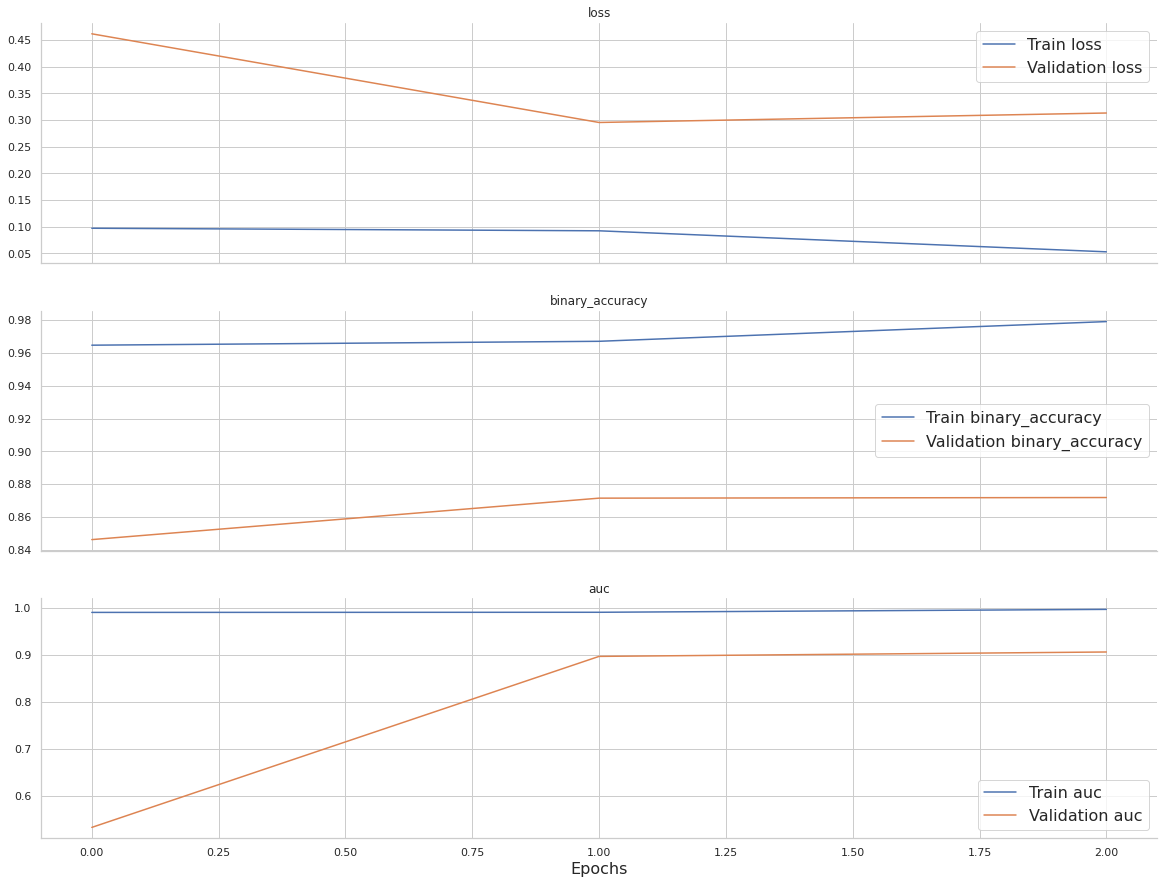

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
# display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

# Confusion matrix

In [10]:
# for n_fold in range(config['N_FOLDS']):
#     print('Fold: %d' % (n_fold+1))
#     train_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
#     validation_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation'] 
#     plot_confusion_matrix(train_set['toxic'], train_set['pred_%d' % (n_fold+1)], 
#                           validation_set['toxic'], validation_set['pred_%d' % (n_fold+1)])

# Model evaluation by language

In [11]:
# display(evaluate_model_lang(valid_df, config['N_FOLDS']).style.applymap(color_map))

# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, jus...",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and ...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on,...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow th...",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


Multilingual validation set


,comment_text,toxic
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0


# Test set predictions

In [13]:
x_test = np.load(database_base_path + 'x_test.npy')

In [14]:
import glob
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
model_path_list.sort()
print('Models to predict:')
print(*model_path_list, sep = "\n")

Models to predict:
/kaggle/working/model_fold_1.h5


In [15]:
NUM_TEST_IMAGES = len(x_test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))

for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print(model_path)
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        model.load_weights(model_path)

    test_preds += model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO)) / len(model_path_list)

/kaggle/working/model_fold_1.h5


In [16]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.156092
std,18421.082026,0.223712
min,0.000000,0.001056
25%,15952.750000,0.029117
50%,31905.500000,0.042233
75%,47858.250000,0.168748
max,63811.000000,0.884881


,id,toxic
0,0,0.070595
1,1,0.025223
2,2,0.090946
3,3,0.028602
4,4,0.002506
5,5,0.036774
6,6,0.028009
7,7,0.041532
8,8,0.571627
9,9,0.112549
